In [1]:
!pip install tensorflow==2

     |████████████████████████████████| 86.3MB 91kB/s 
     |████████████████████████████████| 450kB 43.5MB/s 
     |████████████████████████████████| 3.8MB 46.9MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-11-02 11:45:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c0c::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-11-02 11:45:58 (106 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



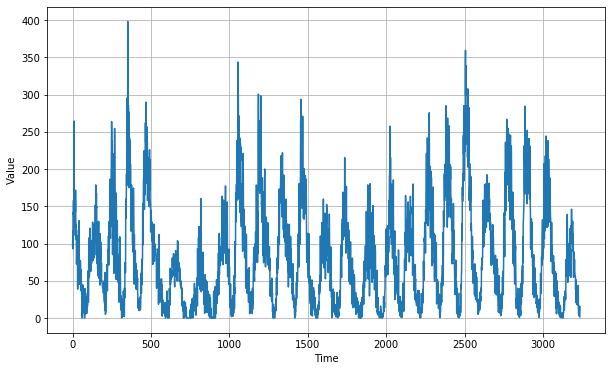

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

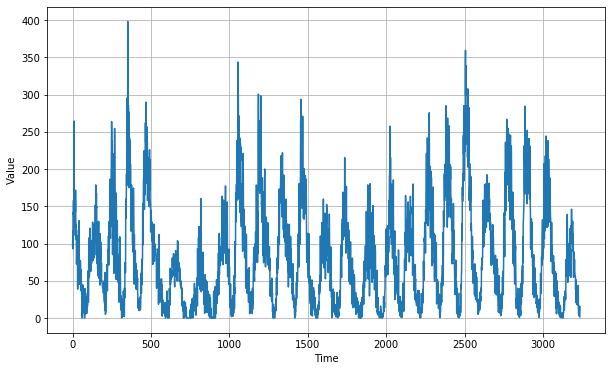

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 9s 790ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 6s 459ms/step - loss: 77.9405 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 5s 457ms/step - loss: 75.2415 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 5s 455ms/step - loss: 72.2421 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 5s 457ms/step - loss: 68.5302 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 5s 454ms/step - loss: 64.8655 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 6s 459ms/step - loss: 61.1551 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 6s 458ms/step - loss: 58.2311 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 6s 460ms/step - loss: 54.7059 - mae: 55.5682
Epoch 10/100
12/

[1e-08, 0.0001, 0, 60]

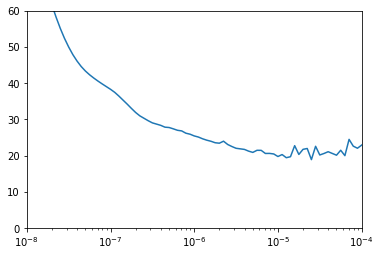

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 9s 296ms/step - loss: 37.8898 - mae: 38.6062
Epoch 2/500
30/30 [==============================] - 5s 167ms/step - loss: 24.1475 - mae: 24.6120
Epoch 3/500
30/30 [==============================] - 5s 165ms/step - loss: 22.0299 - mae: 22.5216
Epoch 4/500
30/30 [==============================] - 5s 167ms/step - loss: 19.8069 - mae: 20.3058
Epoch 5/500
30/30 [==============================] - 5s 166ms/step - loss: 19.4337 - mae: 19.9283
Epoch 6/500
30/30 [==============================] - 5s 166ms/step - loss: 19.2755 - mae: 19.7643
Epoch 7/500
30/30 [==============================] - 5s 162ms/step - loss: 18.7666 - mae: 19.2646
Epoch 8/500
30/30 [==============================] - 5s 162ms/step - loss: 18.3358 - mae: 18.8270
Epoch 9/500
30/30 [==============================] - 5s 163ms/step - loss: 18.9647 - mae: 19.4666
Epoch 10/500
30/30 [==============================] - 5s 164ms/step - loss: 18.4856 - mae: 18.9846
Epoch 11/500
30/30 

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

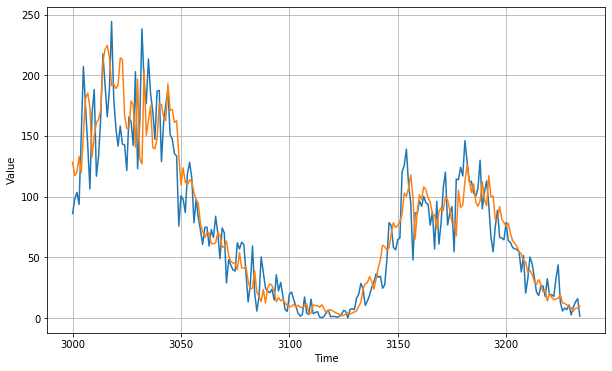

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.465754

<Figure size 432x288 with 0 Axes>

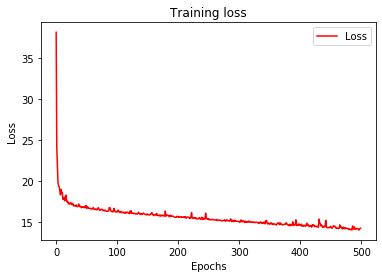

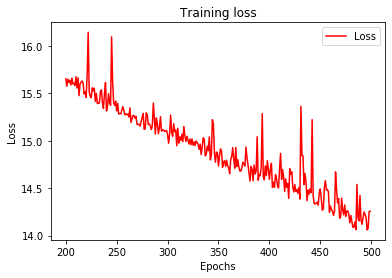

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[128.34058   117.36959   120.21221   132.9964    119.64408   152.58786
 181.13803   185.29076   173.63475   132.6062    150.20526   160.88815
 163.61447   171.61197   211.39217   221.32239   224.66443   214.8448
 191.54178   192.60901   189.11853   191.98352   214.38405   212.87851
 166.91495   156.36555   155.82523   178.84999   175.02908   140.73271
 196.68854   131.36443   126.95976   204.3727    150.5691    162.80179
 174.71324   140.41599   139.38342   147.95525   176.58795   175.7258
 165.33727   162.73628   193.00378   171.122     171.76006   161.18188
 162.52214   134.54166   109.517654  123.663284  112.04064   109.65196
 113.83678   112.192474  103.10232    97.70291    94.381096   77.466324
  71.36468    66.25992    70.35916    69.88442    61.27887    61.12542
  62.034565   70.3916     68.30441    58.10794    59.131485   63.385876
  51.6235     46.63688    45.235954   45.366383   39.75632    53.87586
  41.329395   40.827908   42.400898   30.238804   24.05354    24.577883
  38.